In [1]:
# Description: Plot Figure 2 (Surface velocity profiles).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        May/2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from xarray import open_dataset, DataArray
from ap_tools.stats import arsig
from ap_tools.utils import near
from gsw import f as fcor

In [3]:
fnames = ["GulfStream33N", "GulfStream34N", "GulfStream36N", "GulfStream37N", "GulfStream38N", "AgulhasCurrent", "EAC29S", "BrazilCurrent29S", "KuroshioCurrent25N", "KuroshioCurrent28p5N", "SAFjet", "PFjet", "SACCFjet", "LMGshfbrk"]

head_deriv = "../../data/derived/"
ACCjets = ["SAFjet", "PFjet", "SACCFjet"]
ADCPjets = ["SAFjet", "PFjet", "SACCFjet", "LMGshfbrk"]

In [4]:
Ldls_surf, Ldrs_surf, Ljls, Ljrs, xss, uss, fs, cols, linestyles = [], [], [], [], [], [], [], [], []
LjonLdls, LjonLdrs = [], []
lats = []
for f in fnames:
    d = np.load(head_deriv + f + ".npz")
    x, us = d["x"], d["us"]
    lat0 = d["lat0"].flatten()[0]
    Ldlsurf, Ldrsurf = d["Ldlsurf"].flatten()[0], d["Ldrsurf"].flatten()[0]
    Ljl, Ljr = d["Ljl"].flatten()[0], d["Ljr"].flatten()[0]

    if f in ACCjets:
        linestyles.append("dashed")
    else:
        linestyles.append("solid")

    if f in ADCPjets:
        cols.append("m")
    else:
        cols.append("k")

    lats.append(lat0)
    Ldls_surf.append(Ldlsurf)
    Ldrs_surf.append(Ldrsurf)
    Ljls.append(Ljl)
    Ljrs.append(Ljr)
    LjonLdls.append(Ljl/Ldlsurf)
    LjonLdrs.append(Ljr/Ldrsurf)
    xss.append(x)
    uss.append(us)
    fs.append(f)

### Plot all time-averaged jet profiles.

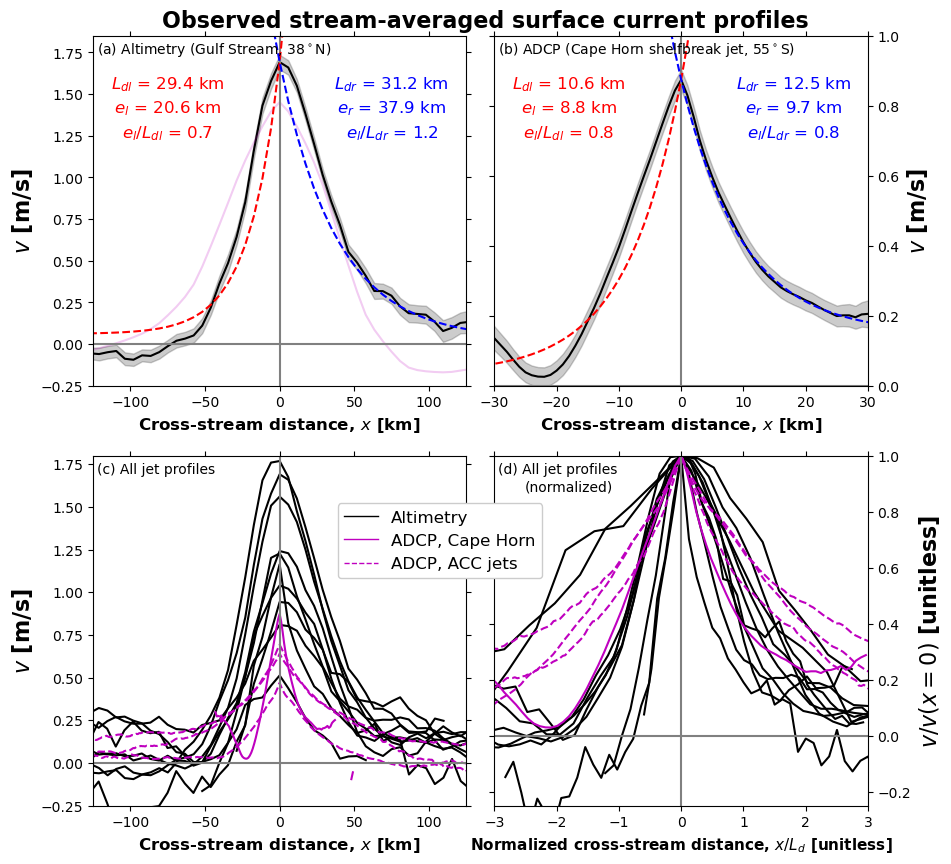

In [5]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax1, ax2 = ax[0]
ax3, ax4 = ax[1]
xlabel = "Cross-stream distance, $x$ [km]"

# (a) Gulf Stream jet example.
d = np.load(head_deriv + "GulfStream38N.npz")
xs = d["x"]
us = d["us"]
Ldlsurf, Ldrsurf = d["Ldlsurf"], d["Ldrsurf"]
Ldlflat, Ldrflat = d["Ldlflat"], d["Ldrflat"]
Ljl, Ljr = d["Ljl"], d["Ljr"]
ypl = d["ypl"]
ypr = d["ypr"]
vADT = d["vADT"]

CL95l, CL95u = d["CL95l"], d["CL95u"]
cl, cr = "r", "b"
cl2, cr2 = "r--", "b--"

ax1.plot(xs, us, "k")
ax1.plot(xs, vADT, "m", alpha=0.2)
ax1.fill_between(xs, CL95l, CL95u, color="k", alpha=0.2)
ax1.axhline(color="gray", linestyle="solid")
ax1.axvline(color="gray", linestyle="solid")

dyt = 0.1
ax1.text(0.2, 0.75+dyt, "$L_{dl}$ = %.1f km"%Ldlsurf, fontsize=12, transform=ax1.transAxes, ha="center", color=cl)
ax1.text(0.8, 0.75+dyt, "$L_{dr}$ = %.1f km"%Ldrsurf, fontsize=12, transform=ax1.transAxes, ha="center", color=cr)
ax1.plot(xs, ypl, cl2)
ax1.plot(xs, ypr, cr2)
ax1.text(0.2, 0.68+dyt, "$e_l$ = %.1f km"%Ljl, fontsize=12, transform=ax1.transAxes, ha="center", color=cl)
ax1.text(0.8, 0.68+dyt, "$e_r$ = %.1f km"%Ljr, fontsize=12, transform=ax1.transAxes, ha="center", color=cr)
ax1.text(0.2, 0.61+dyt, "$e_l/L_{dl}$ = %.1f"%(Ljl/Ldlsurf), fontsize=12, transform=ax1.transAxes, ha="center", color=cl)
ax1.text(0.8, 0.61+dyt, "$e_l/L_{dr}$ = %.1f"%(Ljr/Ldrsurf), fontsize=12, transform=ax1.transAxes, ha="center", color=cr)

ax1.set_xlabel(xlabel, fontsize=12, fontweight="black")
ax1.set_ylabel("$v$ [m/s]", fontsize=16, fontweight="black")

# (b) Shipboard jet example.
d = np.load(head_deriv + "LMGshfbrk.npz")
yplfit = d["ypl"]
yprfit = d["ypr"]
xs = d["x"]
us = d["us"]
Ldlsurf, Ldrsurf = d["Ldlsurf"], d["Ldrsurf"]
Ldlflat, Ldrflat = d["Ldlflat"], d["Ldrflat"]
Ljl, Ljr = d["Ljl"], d["Ljr"]
ypl = d["ypl"]
ypr = d["ypr"]
CL95l, CL95u = d["CL95l"], d["CL95u"]

ax2.plot(xs, us, "k")
ax2.fill_between(xs, CL95l, CL95u, color="k", alpha=0.2)
ax2.axhline(color="gray", linestyle="solid")
ax2.axvline(color="gray", linestyle="solid")

ax2.text(0.2, 0.75+dyt, "$L_{dl}$ = %.1f km"%Ldlsurf, fontsize=12, transform=ax2.transAxes, ha="center", color=cl)
ax2.text(0.8, 0.75+dyt, "$L_{dr}$ = %.1f km"%Ldrsurf, fontsize=12, transform=ax2.transAxes, ha="center", color=cr)
ax2.plot(xs, ypl, cl2)
ax2.plot(xs, ypr, cr2)
ax2.text(0.2, 0.68+dyt, "$e_l$ = %.1f km"%Ljl, fontsize=12, transform=ax2.transAxes, ha="center", color=cl)
ax2.text(0.8, 0.68+dyt, "$e_r$ = %.1f km"%Ljr, fontsize=12, transform=ax2.transAxes, ha="center", color=cr)
ax2.text(0.2, 0.61+dyt, "$e_l/L_{dl}$ = %.1f"%(Ljl/Ldlsurf), fontsize=12, transform=ax2.transAxes, ha="center", color=cl)
ax2.text(0.8, 0.61+dyt, "$e_l/L_{dr}$ = %.1f"%(Ljr/Ldrsurf), fontsize=12, transform=ax2.transAxes, ha="center", color=cr)

ax2.set_xlabel(xlabel, fontsize=12, fontweight="black")
ax2.set_ylabel("$v$ [m/s]", fontsize=16, fontweight="black")

for xs, us, Ldl, Ldr, Ljl, Ljr, f, col, ls in zip(xss, uss, Ldls_surf, Ldrs_surf, Ljls, Ljrs, fs, cols, linestyles):
    ax3.plot(xs, us, color=col, linestyle=ls)

    us_norm = us/us[xs==0]
    xpLd = xs.copy()
    xpLd[xpLd<0] = xpLd[xpLd<0]/Ldl
    xpLd[xpLd>0] = xpLd[xpLd>0]/Ldr

    ax4.plot(xpLd, us_norm, color=col, linestyle=ls)

xclip = 125
xclip2 = 30
minuclip = -0.25
ax1.set_xlim(-xclip, xclip)
ax1.set_ylim(minuclip, 1.85)
ax2.set_xlim(-xclip2, xclip2)
ax2.set_ylim(0, 1.0)
ax3.set_xlim(-xclip, xclip)
ax3.set_ylim(minuclip, 1.8)
ax4.set_xlim(-3, 3)
ax4.set_ylim(minuclip, 1)
ax3.axhline(color="gray", linestyle="solid")
ax3.axvline(color="gray", linestyle="solid")
ax4.axhline(color="gray", linestyle="solid")
ax4.axvline(color="gray", linestyle="solid")
ax1.tick_params(bottom=True, top=True, left=True, right=True)
ax3.tick_params(bottom=True, top=True, left=True, right=True)
ax2.tick_params(bottom=True, top=True, left=True, right=True, labelleft=False, labelright=True)
ax4.tick_params(bottom=True, top=True, left=True, right=True, labelleft=False, labelright=True)
ax2.yaxis.set_label_position("right"); ax4.yaxis.set_label_position("right")
ax3.set_xlabel(xlabel, fontsize=12, fontweight="black")
ax3.set_ylabel("$v$ [m/s]", fontsize=16, fontweight="black")
ax4.set_xlabel("Normalized cross-stream distance, $x/L_d$ [unitless]", fontsize=11, fontweight="black")
ax4.set_ylabel("$v/v(x=0)$ [unitless]", fontsize=16, fontweight="black")

xd, yd = [np.nan], [np.nan]
h1 = Line2D(xd, yd, color="k", linestyle="solid", linewidth=1)
h2 = Line2D(xd, yd, color="m", linestyle="solid", linewidth=1)
h3 = Line2D(xd, yd, color="m", linestyle="dashed", linewidth=1)

hs = [h1, h2, h3]
labs = ["Altimetry", "ADCP, Cape Horn", "ADCP, ACC jets"]
ax4.legend(hs, labs, fontsize=12, frameon=True, framealpha=1, loc=(-0.42, 0.65))

xt, yt = 0.01, 0.95
ax1.text(xt, yt, "(a) Altimetry (Gulf Stream, 38$^\circ$N)", fontsize=10, transform=ax1.transAxes)
ax2.text(xt, yt, "(b) ADCP (Cape Horn shelfbreak jet, 55$^\circ$S)", fontsize=10, transform=ax2.transAxes)
ax3.text(xt, yt, "(c) All jet profiles", fontsize=10, transform=ax3.transAxes)
ax4.text(xt, yt, "(d) All jet profiles", fontsize=10, transform=ax4.transAxes)
ax4.text(xt+0.07, yt-0.05, "(normalized)", fontsize=10, transform=ax4.transAxes)

ax1.set_title("Observed stream-averaged surface current profiles", fontsize=16, fontweight="black", x=1.05)
fig.subplots_adjust(wspace=0.075)

In [6]:
fig.savefig("fig02.png", bbox_inches="tight", dpi=150)